In [9]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization

SOL_df = data.load_asset('SOLUSDT')
SOL_df = data.subset(SOL_df, start=pd.Timestamp('2024-06-01 08:00:00'), end=pd.Timestamp('2026-01-01'))
data.report_and_print_gaps(SOL_df)

SOL_df = data.add_returns(SOL_df)
SOL_df.dropna(inplace=True)
SOL_df = data.train_test_split(SOL_df)
print(SOL_df.columns)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Return', 'Return_Target', 'SPLIT'],
      dtype='object')


In [10]:
# normalize all features but not targets
Fbutnt_df = SOL_df.copy()

numerical_columns = categorical_columns = "all"
exclude_columns = ['Return_Target']
Fbutnt_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Return']
Fbutnt_df, Fbutnt_columns = data.normalize_data(Fbutnt_df, exclude_columns=exclude_columns)

# fewer features (OHLC, Volume)
Fewerf_df = SOL_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return_Target']].copy()

numerical_columns = categorical_columns = "all"
exclude_columns = ["Return_Target"]
Fewerf_features = ['Open', 'High', 'Low', 'Close', 'Volume']
Fewerf_df, Fewerf_columns = data.normalize_data(Fewerf_df, exclude_columns=exclude_columns)

# vs. normalize all features AND targets
Fandt_df = SOL_df.copy()

numerical_columns = categorical_columns = "all"
exclude_columns = []
Fandt_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Return']
Fandt_df, Fandt_columns = data.normalize_data(Fandt_df, exclude_columns=exclude_columns)


Fbutnt_columns, Fewerf_columns, Fandt_columns

({'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': MinMaxScaler(),
  'Close': MinMaxScaler(),
  'Volume': MinMaxScaler(),
  'Quote asset volume': MinMaxScaler(),
  'Number of trades': MinMaxScaler(),
  'Taker buy base asset volume': MinMaxScaler(),
  'Taker buy quote asset volume': MinMaxScaler(),
  'Return': MinMaxScaler(),
  'Return_Target': 'standard',
  'SPLIT': 'standard'},
 {'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': MinMaxScaler(),
  'Close': MinMaxScaler(),
  'Volume': MinMaxScaler(),
  'Return_Target': 'standard'},
 {'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': MinMaxScaler(),
  'Close': MinMaxScaler(),
  'Volume': MinMaxScaler(),
  'Quote asset volume': MinMaxScaler(),
  'Number of trades': MinMaxScaler(),
  'Taker buy base asset volume': MinMaxScaler(),
  'Taker buy quote asset volume': MinMaxScaler(),
  'Return': MinMaxScaler(),
  'Return_Target': MinMaxScaler(),
  'SPLIT': 'standard'})

In [4]:
Fbutnt_df = data.train_test_split(Fbutnt_df)
Fewerf_df = data.train_test_split(Fewerf_df)
Fandt_df = data.train_test_split(Fandt_df)

episode_lengths = [10, 30]
train_X_y_s = [
    [
        LSTM_returns.vectorize_train_data(df, features=features, episode_length=e) for e in episode_lengths
    ] for df, features in zip(
        [Fbutnt_df, Fewerf_df, Fandt_df],
        [Fbutnt_features, Fewerf_features, Fandt_features]
    )
]

In [4]:
import json
importlib.reload(LSTM_returns)

hyperparams_list = [
    {
        '__+ABD_exceptLast': False
    },
    {
        'batch_size': 16
    },
    {
        'layers': [64, 64, 64]
    },
    {
        'LSTM_activation': 'relu'
    },
    {
        'optimizer': 'adam'
    },
    {
        'loss': 'mean_absolute_error'
    },
    {
        'loss': 'huber'
    },
    {
        'dropout': 0
    },
    {
        '__finalAct': 'sigmoid'
    },
    {
        '__penultRelu': True
    }
]

Fbutnt_LSTMs = []
for e_l, train_X_y in zip(episode_lengths, train_X_y_s[0]):
    for hyperparams in hyperparams_list:
        str_hyperparams = json.dumps(hyperparams)

        hyperparams['input_shape'] = train_X_y['train_X'].shape[1:]
        hyperparams['epochs'] = 30
        LSTM = LSTM_returns.create(hyperparams)
        LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)
        plt = LSTM_returns.all_folds_plot(LSTM, train_X_y)
        plt.title(f"EL: {e_l}; HP: {str_hyperparams}")
        plt.show()

Epoch 1/30


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.1256e-04 - mae: 0.0137
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7418e-05 - mae: 0.0076
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8872e-05 - mae: 0.0062
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5801e-05 - mae: 0.0060
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2249e-05 - mae: 0.0058
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8097e-05 - mae: 0.0055
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7806e-05 - mae: 0.0054
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4761e-05 - mae: 0.0052
Epoch 9/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4935e-05 - mae: 0.0052
Epoch 10/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5956e-05 - mae: 0.0053
Epoch 11/30
 38/365 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7227e-05 - mae: 0.0049

KeyboardInterrupt: 

[I 2025-04-25 16:55:27,436] A new study created in memory with name: no-name-5022e9d5-d298-4658-a3dd-b30c9ccae681
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0026 - mae: 0.0368


[I 2025-04-25 16:55:29,435] Trial 0 finished with value: 0.0021960772573947906 and parameters: {'lstm_units': 38, 'num_layers': 1, 'epochs': 1, 'batch_size': 115, 'dropout_rate': 0.3164607733501724, 'learning_rate': 0.0028803829311396926, 'lstm_activation': 'tanh', 'activation': 'sigmoid', '__+ABD_exceptLast': True, '__finalAct': 'tanh', '__penultRelu': True, 'optimizer': 'rmsprop', 'episode_length': 63}. Best is trial 0 with value: 0.0021960772573947906.


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 63; HP: {"lstm_units": 38, "num_layers": 1, "epochs": 1, "batch_size": 115, "dropout": 0.3164607733501724, "learning_rate": 0.0028803829311396926, "LSTM_activation": "tanh", "activation": "sigmoid", "__+ABD_exceptLast": true, "__finalAct": "tanh", "__penultRelu": true, "optimizer": "rmsprop", "episode_length": 63, "layers": [38], "loss": "mean_squared_error", "input_shape": [63, 10]}


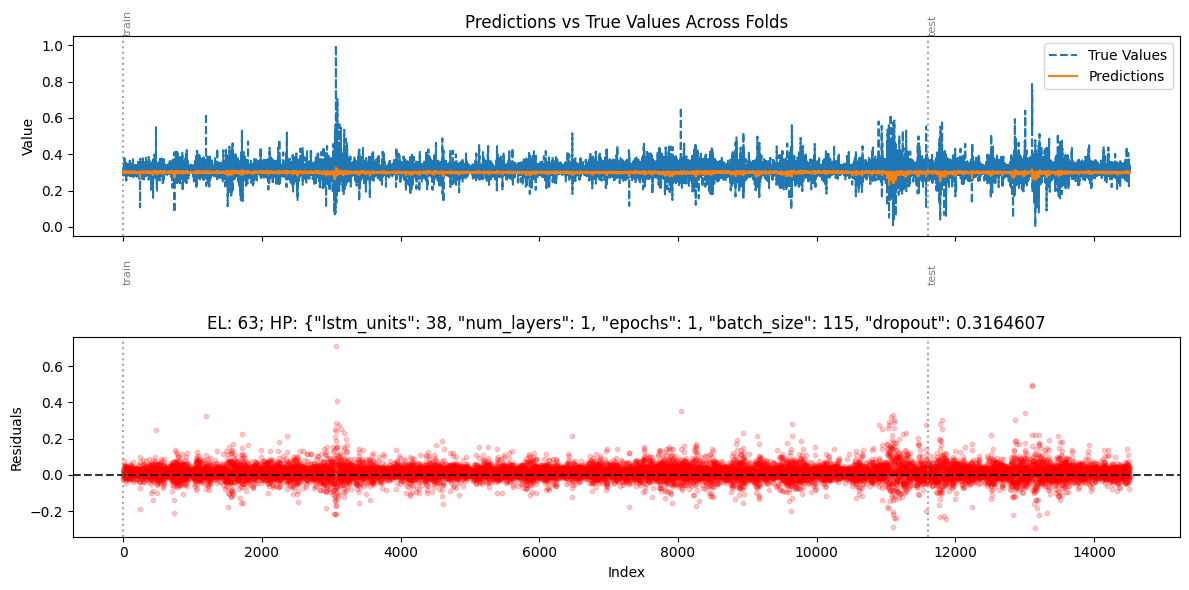

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0170 - mae: 0.0948


[I 2025-04-25 16:55:39,680] Trial 1 finished with value: 0.010362238623201847 and parameters: {'lstm_units': 58, 'num_layers': 4, 'epochs': 1, 'batch_size': 66, 'dropout_rate': 0.05429677159424895, 'learning_rate': 4.416764300654706e-05, 'lstm_activation': 'relu', 'activation': 'tanh', '__+ABD_exceptLast': True, '__finalAct': 'tanh', '__penultRelu': False, 'optimizer': 'sgd', 'episode_length': 52}. Best is trial 0 with value: 0.0021960772573947906.


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 63; HP: {"lstm_units": 38, "num_layers": 1, "epochs": 1, "batch_size": 115, "dropout": 0.3164607733501724, "learning_rate": 0.0028803829311396926, "LSTM_activation": "tanh", "activation": "sigmoid", "__+ABD_exceptLast": true, "__finalAct": "tanh", "__penultRelu": true, "optimizer": "rmsprop", "episode_length": 63, "layers": [38], "loss": "mean_squared_error", "input_shape": [63, 10]}


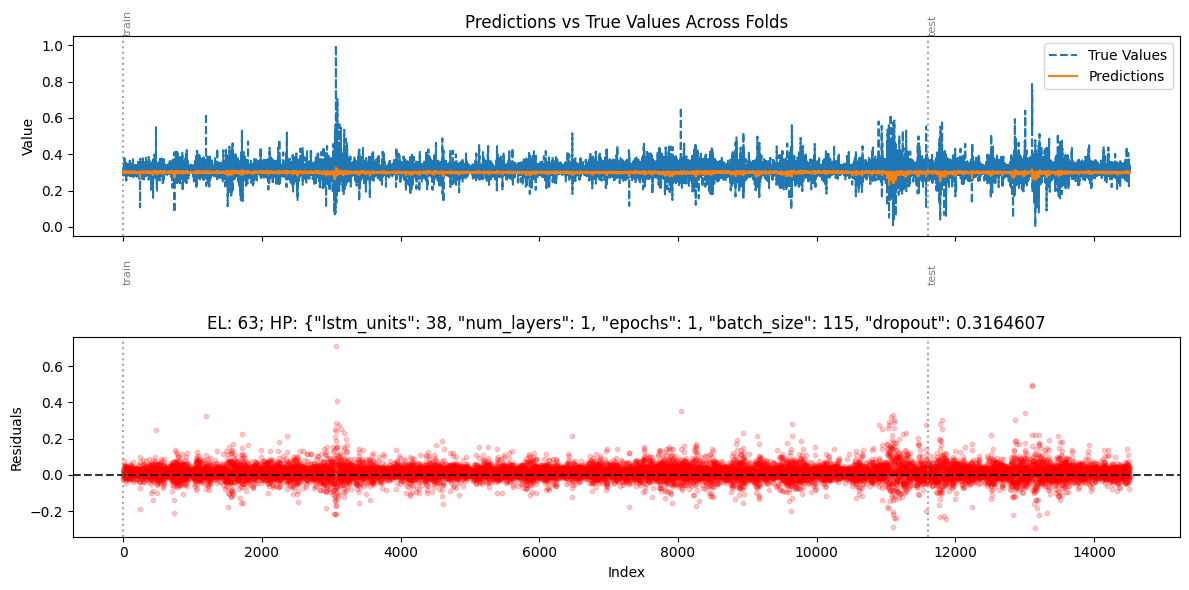

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0074 - mae: 0.0565


[I 2025-04-25 16:55:43,160] Trial 2 finished with value: 0.003029860556125641 and parameters: {'lstm_units': 45, 'num_layers': 1, 'epochs': 1, 'batch_size': 66, 'dropout_rate': 0.20811791178468286, 'learning_rate': 0.0027523240344347727, 'lstm_activation': 'tanh', 'activation': 'sigmoid', '__+ABD_exceptLast': False, '__finalAct': 'tanh', '__penultRelu': False, 'optimizer': 'sgd', 'episode_length': 45}. Best is trial 0 with value: 0.0021960772573947906.


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 63; HP: {"lstm_units": 38, "num_layers": 1, "epochs": 1, "batch_size": 115, "dropout": 0.3164607733501724, "learning_rate": 0.0028803829311396926, "LSTM_activation": "tanh", "activation": "sigmoid", "__+ABD_exceptLast": true, "__finalAct": "tanh", "__penultRelu": true, "optimizer": "rmsprop", "episode_length": 63, "layers": [38], "loss": "mean_squared_error", "input_shape": [63, 10]}


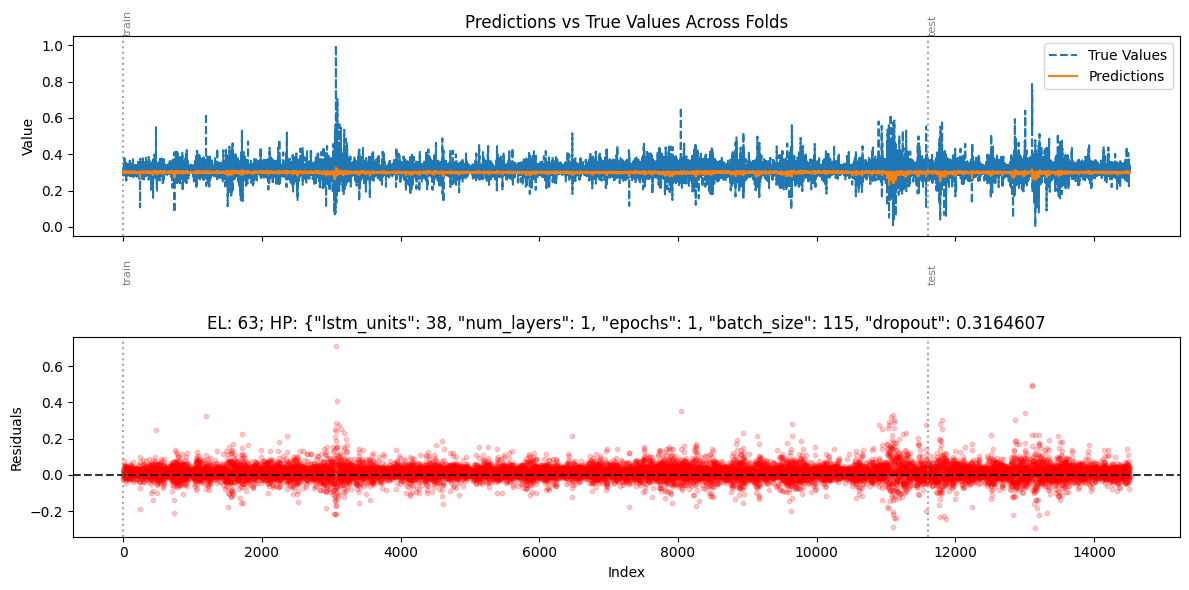

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - mae: 0.0298


[I 2025-04-25 16:55:47,055] Trial 3 finished with value: 0.0017094479408115149 and parameters: {'lstm_units': 40, 'num_layers': 2, 'epochs': 1, 'batch_size': 128, 'dropout_rate': 0.1305861806146692, 'learning_rate': 6.558734179894992e-05, 'lstm_activation': 'relu', 'activation': 'sigmoid', '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', '__penultRelu': True, 'optimizer': 'rmsprop', 'episode_length': 23}. Best is trial 3 with value: 0.0017094479408115149.


364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
EL: 23; HP: {"lstm_units": 40, "num_layers": 2, "epochs": 1, "batch_size": 128, "dropout": 0.1305861806146692, "learning_rate": 6.558734179894992e-05, "LSTM_activation": "relu", "activation": "sigmoid", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "__penultRelu": true, "optimizer": "rmsprop", "episode_length": 23, "layers": [40, 40], "loss": "mean_squared_error", "input_shape": [23, 10]}


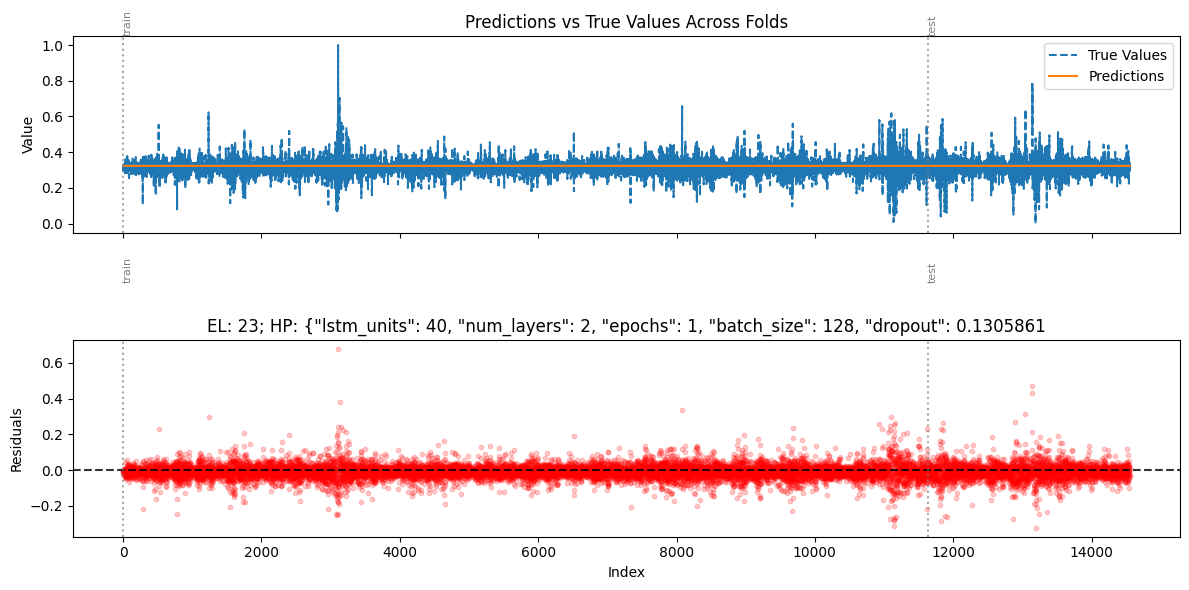

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[W 2025-04-25 16:55:49,325] Trial 4 failed with parameters: {'lstm_units': 63, 'num_layers': 3, 'epochs': 1, 'batch_size': 20, 'dropout_rate': 0.33532810746105324, 'learning_rate': 6.702666542196152e-05, 'lstm_activation': 'tanh', 'activation': 'sigmoid', '__+ABD_exceptLast': True, '__finalAct': 'tanh', '__penultRelu': False, 'optimizer': 'rmsprop', 'episode_length': 69} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ic2594\AppData\Local\Temp\ipy

KeyboardInterrupt: 

In [ ]:
import json
import optuna
from IPython.display import display, HTML
import joblib

importlib.reload(LSTM_returns)

Log = []

def objective(trial):
    entry = {}
    # Example of hyperparameter suggestions
    hyperparams = {
        'lstm_units': trial.suggest_int('lstm_units', 32, 80), # 10 to 100
        'num_layers': trial.suggest_int('num_layers', 1, 4), # 1 to 5
        'epochs': trial.suggest_int('epochs', 1, 10), # 1 to 30
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'dropout': trial.suggest_float('dropout_rate', 0.0, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'LSTM_activation': trial.suggest_categorical('lstm_activation', ['relu', 'tanh']),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        '__+ABD_exceptLast': trial.suggest_categorical('__+ABD_exceptLast', [True, False]),
        '__finalAct': trial.suggest_categorical('__finalAct', ['sigmoid', 'tanh']),
        '__penultRelu': trial.suggest_categorical('__penultRelu', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        # 'loss': trial.suggest_categorical('loss', ['mean_squared_error', 'mean_absolute_error', 'huber']),
    }
    episode_lengths = trial.suggest_int('episode_length', 5, 80)
    hyperparams['episode_length'] = episode_lengths
    hyperparams['layers'] = [hyperparams['lstm_units']] * hyperparams['num_layers']
    hyperparams['loss'] = 'mean_squared_error'
    # hyperparams['batch_size'] = 128
    # hyperparams['epochs'] = 1  # Set to 1 for quick testing; increase for actual training

    
    # Placeholder for model training and evaluation
    train_X_y = LSTM_returns.vectorize_train_data(Fandt_df, features=Fandt_features, episode_length=episode_lengths)
    hyperparams['input_shape'] = train_X_y['train_X'].shape[1:]
    
    LSTM = LSTM_returns.create(hyperparams)
    results = LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)

    entry['hyperparams'] = hyperparams
    entry['results'] = results
    # entry['plot'] = LSTM_returns.all_folds_plot(LSTM, train_X_y)
    entry['plot-title'] = f"EL: {episode_lengths}; HP: {json.dumps(hyperparams)}"
    entry['model'] = LSTM
    entry['train_X_y'] = train_X_y
    Log.append(entry)

    return results.history['loss'][-1]  # Return the last loss value as the score


# Example Optuna study
study = optuna.create_study(direction='minimize')  # or 'maximize' depending on the objective

for i in range(50):
    study.optimize(objective, n_trials=10)

    best_entry = [
        entry for entry in Log if entry['results'].history['loss'][-1] == study.best_value
    ][-1]

    # Print the best hyperparameters
    # Display the best hyperparameters and score in purple
    display(HTML(f"""
    <div style="color: purple; background: orange; font-weight: bold;">
        Trial {i+1} completed.<br>
        Best hyperparameters: {study.best_params}<br>
        Best score (MSE): {study.best_value}<br>
    </div>
    """))

    # Display the best entry plot
    plt = LSTM_returns.all_folds_plot(
        best_entry['model'], best_entry['train_X_y']
    )
    plt.title(best_entry['plot-title'][:100])
    print(best_entry['plot-title'])
    plt.show()

    joblib.dump(study, 'expt1.3-model-store/study.pkl')
    joblib.dump(Log, 'expt1.3-model-store/Log.pkl')

In [13]:
[value.shape for key, value in best_entry['train_X_y'].items()]

[(11593, 67, 10), (11593,), (2915, 67, 10), (2915,), (11593,), (2915,)]